# 작성함수
- preprocess()
    - 매개변수로 받은 영상을 모델이 추론할 수 있도록 전처리
    - 전처리
        - resize
            - movenet thunder: 32배수 크기로 resize. 최대 256이되지 않도록 한다.
            - movenet lightning: 32배수 크기로 resize. 최대 192가 되지 않도록 한다.
        - type: int32로 변환한다.
        
- get_model()
    - tensorflow hub에서 Movenet 모델을 다운받아 리턴하는 함수
- draw_keypoints()
    - 모델이 찾은 keypoints(관절)을 원본 이미지 영상에 표시한다.
- draw_edges()
    - keypoint들을 연결하는 것을 원본 이미지에 표시한다.
    
- detect_image()
    - 이미지 영상으로 부터 추론
- detect_video()
    - 동영상으로 부터 추론

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

## 전처리 함수

In [58]:
def preprocess(frame, resize=256):
    """
    전처리 함수
    opencv로 읽은 frame을 받아서
    1. BGR -> RGB 변환
    2. resize 크기로 이미지를 resize, 종횡비는 유지한다.
    3. int32 타입으로 변환
    4. 배치 axis 추가
    [parameter]
        frame: ndarray - 전처리할 이미지 데이터 (BGR 모드)
        resize: int = 256 - resize할 이미지의 size
    [return]
        tf.Tensor: 전처리한 이미지 (원본에 대한 복사본을 반환한다.)
    """
    # BGR -> RGB + batch axis 추가
    input_tensor = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)[np.newaxis, ...]
    # resize : thunder - 256 X 256
    input_tensor = tf.image.resize_with_pad(input_tensor, resize, resize) # 원본 이미지의 종횡비를 유지하면서 resize
    # int32 로 형변환
    input_tensor = tf.cast(input_tensor, dtype=tf.int32)
    return input_tensor

In [59]:
preprocess(cv2.imread('test_image/babel1.jpg'))

<tf.Tensor: shape=(1, 256, 256, 3), dtype=int32, numpy=
array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]])>

In [60]:
v = preprocess(cv2.imread('test_image/babel1.jpg'))
print(type(v), v.shape, v.dtype) # ndarray(1, 256, 256, 3), int32

<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 256, 256, 3) <dtype: 'int32'>


## 모델 로딩 함수
- https://tfhub.dev/s?module-type=image-pose-detection

In [61]:
def get_model(version='thunder'):
    """
    Tensorflow Hub에서 Movenet모델을 받아 loading한뒤 반환
    [parameter]
        version: str = 'thunder' - 받을 Movenet 버전, thunder:기본값, lighting 둘 중 어떤 것을 받을지 설정
    """
    if version == 'thunder':
        model = hub.load('https://tfhub.dev/google/movenet/singlepose/thunder/4')
    elif version == 'lighting':
        model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
    else:
        return print('wrong version')
    
    movenet = model.signatures['serving_default']
    return movenet

## keypoint/edge 그리기 함수

In [62]:
EDGE_LINK = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (0, 5),
    (0, 6),
    (5, 7),
    (7, 9),
    (6, 8),
    (8, 10),
    (5, 6),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16)
]

In [63]:
def draw_keypoints(frame, pred, score_threshold=0.3):
    """
    이미지에 모델이 추론한 keypoint들의 위치를 점으로 표시하는 함수.
    [parameter]
        frame: ndarray - keypoint들을 그릴 이미지. (원본 크기의 width/height 동일하게 resize한 이미지-종횡비 유지)
        pred: dictionary - Movenet 모델이 추론한 추론 결과
        score_threshold: float = 0.3 - 표시할 keypoint들의 confidence score 입계값, 지정한 값 이상의 것들만 표시
    [return]
        tuple: (ndarray: keypoint들을 표시한 이미지, ndarray: denormalized한 keypoint 좌표 + confidence score)
    """
    h, w, _ = frame.shape
    denormalized_keypoints = pred.numpy().squeeze() * np.array([h, w, 1])
    for kp_y, kp_x, kp_score in denormalized_keypoints:  # keypoint 좌표의 점(원)을 찍기
        if kp_score >= score_threshold:
            cv2.circle(frame, center=(int(kp_x), int(kp_y)), radius = 3, color=[255,255,0], thickness=-1, # 색채우기
                      lineType = cv2.LINE_AA)
    return frame, denormalized_keypoints

In [64]:
def draw_edge(frame, denormalized_keypoints, score_threshold=0.1):
    """
    이미지에 keypoint들을 연결하는 Edge를 표시하는 함수
    [parameter]
        frame: ndarray - edge를 그릴 이미지
        denormalized_keypoints: ndarray - 모델이 추정한 normalized된 keypoint를 이미지의 width/height 크기에 맞춰 denormalize한 keypoint 값들 + confidence score
        score_threshold: float = 0.1 - 표시할 keypoint들의 confidence score 입계값, 지정한 값 이상의 것들만 표시
    [return]
        ndarray: edge를 표시한 이미지
    """
    for edge in EDGE_LINK:
        p1, p2 = edge
        y1, x1, score1 = denormalized_keypoints[p1]
        y2, x2, score2 = denormalized_keypoints[p2]
        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2) # 좌표를 정수로 변환
        # 두 keypoint의 confidence score가 threshold 이상이면 그린다.
        if score1 >= score_threshold and score2 >= score_threshold:
            cv2.line(frame, pt1=(x1, y1), pt2=(x2, y2), color =[0, 255, 255], thickness = 1, lineType=cv2.LINE_AA)
    return frame

## 추론함수

In [65]:
def detect_image(img_path, movenet):
    """
    이미지 경로와 모델을 받아서 추론 후 결과이미지를 출력하는 함수
    """
    image_orig = cv2.imread(img_path)
    input_tensor = preprocess(image_orig)
    outputs = movenet(input_tensor)
    keypoints = outputs['output_0']
    
    h, w, _ = image_orig.shape
    h = w = max(h, w) # 원본 이미지의 height와 width를 큰 쪽으로 통일 -> 추론할 때 width와 height가 같은 크기로 추론했기 때문에 맞춰준다.
    frame = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
    frame = tf.image.resize_with_pad(frame, h, w).numpy().astype('uint8')
    
    frame, denormalized_keypoints = draw_keypoints(frame, keypoints)
    draw_edge(frame, denormalized_keypoints)
    plt.figure(figsize=(7, 7))
    plt.imshow(frame)
    plt.show()

<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 1, 17, 3)


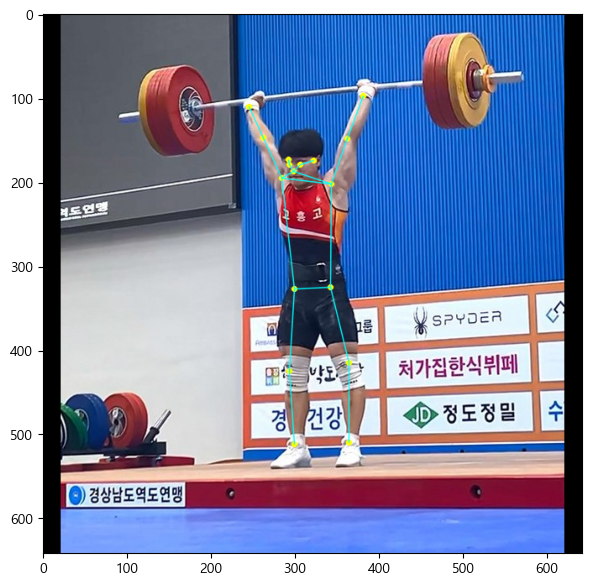

0

In [67]:
img_path = 'test_image/babel2.jpg'
movenet = get_model()

detect_image(img_path, movenet)